**Import libraries**

In [1]:
import sys
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from models.models import *
from utils.utils import *

**Set Arguments**

In [2]:
DEVICE = 'cuda:0'      # 'cuda' or 'cpu'

NUM_CLASSES = 2      # 7 classes for each domain: '0', '1'
DATASETS_NAMES = ['ADC', 'DWI']
CLASSES_NAMES = ['0', '1']

# HYPERPARAMETER -------------------
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 5
# ----------------------------------

# Hyperparameters for grid search
BATCH_SIZE = 128      # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                      # the batch size, learning rate should change by the same factor to have comparable results
LR = 1e-3             # The initial Learning Rate
NUM_EPOCHS = 30       # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20        # How many epochs before decreasing learning rate (if using a step-down policy)
MODE = '3B'           # '3A', '3B', '4A', '4C'
ALPHA = 0.1            # alpha
ALPHA_EXP = False

EVAL_ACCURACY_ON_TRAINING = False
SHOW_IMG = False       # if 'True' show images and graphs on output
SHOW_RESULTS = False   # if 'True' show images and graphs on output

**Define Data Preprocessing**

In [3]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose([ transforms.Resize(224),      # Resizes short size of the PIL image to 256
                              #transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

**Prepare Dataset**

In [4]:
# Define datasets root
#DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ADC = 'Homework3-PACS/ADC_DWI/ADC'
DIR_DWI = 'Homework3-PACS/ADC_DWI/DWI'

# Prepare Pytorch train/test Datasets
#photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
ADC_dataset = torchvision.datasets.ImageFolder(DIR_ADC, transform=transf)
DWI_dataset = torchvision.datasets.ImageFolder(DIR_DWI, transform=transf)

# Check dataset sizes
#print(f"Photo Dataset: {len(photo_dataset)}")
print(f"ADC Dataset: {len(ADC_dataset)}")
print(f"DWI Dataset: {len(DWI_dataset)}")

ADC Dataset: 14002
DWI Dataset: 41795


**Data exploration**

------ Some statistics ------
Total images: 55797
Number of classes: 2
Classes: [0 1]
Classes Names: ['0', '1']

Total images per class: [30231 25566]
Mean images per class: 27898.5
Std images per class: 2332.5

Total images per domain/dataset:
ADC Dataset: 14002
DWI Dataset: 41795

Element per class for each domain:
ADC_dataset: [7640 6362]
DWI_dataset: [22591 19204]


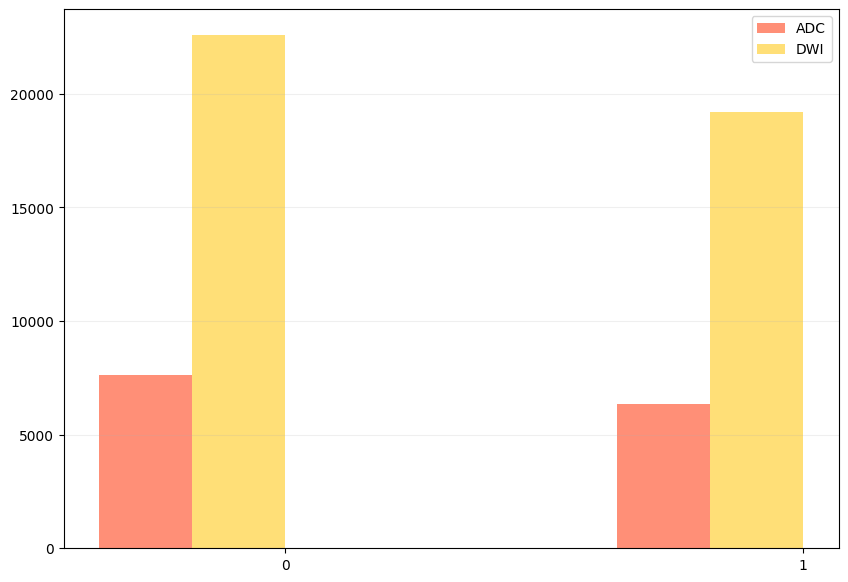

<Figure size 640x480 with 0 Axes>

In [5]:
ADC_dataset.imgs # same of print(photo_dataset.samples)
# [('Homework3-PACS/PACS/photo/dog/056_0001.jpg', 0),
#  ('Homework3-PACS/PACS/photo/dog/056_0002.jpg', 0) ... ]

ADC_dataset.classes
# 'dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'

ADC_dataset.class_to_idx
# {'dog': 0,
#  'elephant': 1,
#  'giraffe': 2,
#  'guitar': 3,
#  'horse': 4,
#  'house': 5,
#  'person': 6}

# dimension of an image 3x227x227
torch.Size([3, 227, 227])

# plot images distribution
#plotImageDistribution(photo_dataset.targets, art_dataset.targets, cartoon_dataset.targets, sketch_dataset.targets, DATASETS_NAMES, CLASSES_NAMES, show=SHOW_IMG)
plotImageDistribution(ADC_dataset.targets, DWI_dataset.targets, dataset_names = DATASETS_NAMES, classes_names = CLASSES_NAMES, show=SHOW_IMG)

**Prepare Dataloaders**

In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
#photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
ADC_dataloader = DataLoader(ADC_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
DWI_dataloader = DataLoader(DWI_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)





**Prepare Network for training**

In [7]:
cudnn.benchmark # Calling this optimizes runtime

if MODE == None :
  raise RuntimeError("Select a MODE")
elif MODE == '3A':  
  # 3A) SENZA DANN	
  USE_DOMAIN_ADAPTATION = False
  CROSS_DOMAIN_VALIDATION = False 
  USE_VALIDATION = False
  ALPHA = None
  transfer_set = None
elif MODE == '3B' : 
  # 3B) Train DANN on Photo and test on Art painting with DANN adaptation
  USE_DOMAIN_ADAPTATION = True 
  USE_VALIDATION = False
  transfer_set = "art painting"
elif MODE == '4A':
  # 4A) Run a grid search on Photo to Cartoon and Photo to Sketch, without Domain Adaptation, and average results for each set of hyperparameters
  transfer_set = 'sketch' # Photo to 'cartoon' or 'sketch'
  USE_VALIDATION = True   # validation on transfer_set
  USE_DOMAIN_ADAPTATION = False
  CROSS_DOMAIN_VALIDATION = False 
  ALPHA = None
  # 4B) when testing
elif MODE == '4C':
  # 4C) Run a grid search on Photo to Cartoon and Photo to Sketch, with Domain Adaptation, and average results for each set of hyperparameters
  USE_VALIDATION = True   # validation on transfer_set
  USE_DOMAIN_ADAPTATION = True
  CROSS_DOMAIN_VALIDATION = True 
  # edit the following hyperparams:
  transfer_set = 'ADC' # Photo to 'cartoon' or 'sketch'


EVAL_ACCURACY_ON_TRAINING = False
SHOW_RESULTS = True

source_dataloader = DWI_dataloader
test_dataloader = ADC_dataloader

# Loading model 
net = dann_net(pretrained=True).to(DEVICE)    
#print(net) #check size output layer OK

# Define loss function: CrossEntrpy for classification
criterion = nn.CrossEntropyLoss()

# Choose parameters to optimize
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer: updates the weights based on loss (SDG with momentum)
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler -> step-down policy which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

if USE_DOMAIN_ADAPTATION and ALPHA == None :
  raise RuntimeError("To use domain adaptation you must define parameter ALPHA")

target_dataloader = ADC_dataloader

if ALPHA_EXP : 
  # ALPHA exponential decaying as described in the paper
  p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
  ALPHA = 2. / (1. + np.exp(-10 * p)) - 1

**Train**

In [8]:
current_step = 0
accuracies_train = []
accuracies_validation = []
loss_class_list = []
loss_target_list = []
loss_source_list = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  
  net.train(True)

  print(f"--- Epoch {epoch+1}/{NUM_EPOCHS}, LR = {scheduler.get_last_lr()}")
  
  # Iterate over the dataset
  for source_images, source_labels in source_dataloader:
    source_images = source_images.to(DEVICE)
    source_labels = source_labels.to(DEVICE)    

    optimizer.zero_grad() # Zero-ing the gradients
    
    # STEP 1: train the classifier
    outputs = net(source_images)          
    loss_class = criterion(outputs, source_labels)  
    loss_class_list.append(loss_class.item())

    # if current_step % LOG_FREQUENCY == 0:
    #   print('Step {}, Loss Classifier {}'.format(current_step+1, loss_class.item()))                
    loss_class.backward()  # backward pass: computes gradients

    # Domain Adaptation (Cross Domain Validation)
    if USE_DOMAIN_ADAPTATION :

      # Load target batch
      target_images, target_labels = next(iter(target_dataloader))
      target_images = target_images.to(DEVICE)

      # if ALPHA_EXP : 
      #   # ALPHA exponential decaying as described in the paper
      #   p = float(i + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
      #   ALPHA = 2. / (1. + np.exp(-10 * p)) - 1

      # STEP 2: train the discriminator: forward SOURCE data to Gd          
      outputs = net.forward(source_images, alpha=ALPHA)
    
      # source's label is 0 for all data    
      labels_discr_source = torch.zeros(BATCH_SIZE, dtype=torch.int64).to(DEVICE)
      loss_discr_source = criterion(outputs, labels_discr_source)  
      loss_source_list.append(loss_discr_source.item())
    
      # if current_step % LOG_FREQUENCY == 0:
      #   print('Step {}, Loss Discriminator Source {}'.format(current_step+1, loss_discr_source.item()))
      loss_discr_source.backward()

      # STEP 3: train the discriminator: forward TARGET to Gd          
      outputs = net.forward(target_images, alpha=ALPHA)           
      labels_discr_target = torch.ones(BATCH_SIZE, dtype=torch.int64).to(DEVICE) # target's label is 1
      loss_discr_target = criterion(outputs, labels_discr_target)    
      loss_target_list.append(loss_discr_target.item())
    
      # if current_step % LOG_FREQUENCY == 0:
        # print('Step {}, Loss Discriminator Target {}'.format(current_step+1, loss_discr_target.item()))
      loss_discr_target.backward()    #update gradients 

    optimizer.step() # update weights based on accumulated gradients          
    
  # --- Accuracy on training
  if EVAL_ACCURACY_ON_TRAINING:
    with torch.no_grad():
      net.train(False)

      running_corrects_train = 0

      for images_train, labels_train in source_dataloader:
        # images, labels = next(iter(source_dataloader))
        images_train = images_train.to(DEVICE)
        labels_train = labels_train.to(DEVICE)

        # Forward Pass
        outputs_train = net(images_train)

        # Get predictions
        _, preds = torch.max(outputs_train.data, 1)

        # Update Corrects
        running_corrects_train += torch.sum(preds == labels_train.data).data.item()

    # Calculate Accuracy
    accuracy_train = running_corrects_train / float(len(source_dataloader)*(target_dataloader.batch_size))
    accuracies_train.append(accuracy_train)
    print('Accuracy on train (photo):', accuracy_train)
    
  # --- VALIDATION SET
  if USE_VALIDATION : 
    # now train is finished, evaluate the model on the target dataset 
    net.train(False) # Set Network to evaluation mode
      
    running_corrects = 0
    for images, labels in target_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      outputs = net(images)
      _, preds = torch.max(outputs.data, 1)
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float( len(target_dataloader)*(target_dataloader.batch_size) )
    accuracies_validation.append(accuracy)
    print(f"Accuracy on validation ({transfer_set}): {accuracy}")

  # Step the scheduler
  current_step += 1
  scheduler.step() 

if SHOW_RESULTS: 
  print()
  print("Loss classifier")
  print(loss_class_list)
  if USE_DOMAIN_ADAPTATION : 
    print("\nLoss discriminator source")
    print(loss_source_list)
    print("\nLoss discriminator target")
    print(loss_target_list)

--- Epoch 1/30, LR = [0.001]
--- Epoch 2/30, LR = [0.001]
--- Epoch 3/30, LR = [0.001]
--- Epoch 4/30, LR = [0.001]
--- Epoch 5/30, LR = [0.001]
--- Epoch 6/30, LR = [0.001]
--- Epoch 7/30, LR = [0.001]
--- Epoch 8/30, LR = [0.001]
--- Epoch 9/30, LR = [0.001]
--- Epoch 10/30, LR = [0.001]
--- Epoch 11/30, LR = [0.001]
--- Epoch 12/30, LR = [0.001]
--- Epoch 13/30, LR = [0.001]
--- Epoch 14/30, LR = [0.001]
--- Epoch 15/30, LR = [0.001]
--- Epoch 16/30, LR = [0.001]
--- Epoch 17/30, LR = [0.001]


Traceback (most recent call last):
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-yi7ofcu5'


--- Epoch 18/30, LR = [0.001]
--- Epoch 19/30, LR = [0.001]
--- Epoch 20/30, LR = [0.001]
--- Epoch 21/30, LR = [0.0001]
--- Epoch 22/30, LR = [0.0001]
--- Epoch 23/30, LR = [0.0001]


Traceback (most recent call last):
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/ytl0623/data/anaconda3/envs/pytorch1.13/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-5xc63oz2'


--- Epoch 24/30, LR = [0.0001]
--- Epoch 25/30, LR = [0.0001]
--- Epoch 26/30, LR = [0.0001]
--- Epoch 27/30, LR = [0.0001]
--- Epoch 28/30, LR = [0.0001]
--- Epoch 29/30, LR = [0.0001]
--- Epoch 30/30, LR = [0.0001]

Loss classifier
[2.105963706970215, 1.2891247272491455, 1.0674625635147095, 0.7625214457511902, 0.7048409581184387, 0.7949092984199524, 0.7247415781021118, 0.6844038367271423, 0.8595500588417053, 0.6761888265609741, 0.736247181892395, 0.7188238501548767, 0.7140763401985168, 0.7294558882713318, 0.7431524991989136, 0.6739755272865295, 0.6981170177459717, 0.665907084941864, 0.682349681854248, 0.8015843629837036, 0.6842808127403259, 0.7115391492843628, 0.668378472328186, 0.6901571154594421, 0.6798670291900635, 0.6682315468788147, 0.7196040153503418, 0.6748223304748535, 0.6486765742301941, 0.6653703451156616, 0.7289198637008667, 0.6473247408866882, 0.6858219504356384, 0.763710618019104, 0.6762714385986328, 0.6585394144058228, 0.7102130651473999, 0.6965845823287964, 0.671797513

**Test**

In [9]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(ADC_dataset))

print('\nTest Accuracy (ADC): {} ({} / {})'.format(accuracy, running_corrects, len(ADC_dataset)))

100%|█████████████████████████████████████████████████████████████████| 109/109 [00:11<00:00,  9.32it/s]


Test Accuracy (ADC): 0.5620625624910727 (7870 / 14002)


In [10]:
#beep()
if USE_VALIDATION : 
  print(f"Validation on:  {transfer_set}")
  print(f"accuracy_valid: {accuracies_validation[-1]:.4f}")
print(f"Test accuracy:  {accuracy:.4f}")
print(f"Val on {transfer_set}, LR = {LR}, ALPHA = {ALPHA}, BATCH_SIZE = {BATCH_SIZE}")
print(accuracies_validation)

Test accuracy:  0.5621
Val on art painting, LR = 0.001, ALPHA = 0.1, BATCH_SIZE = 128
[]


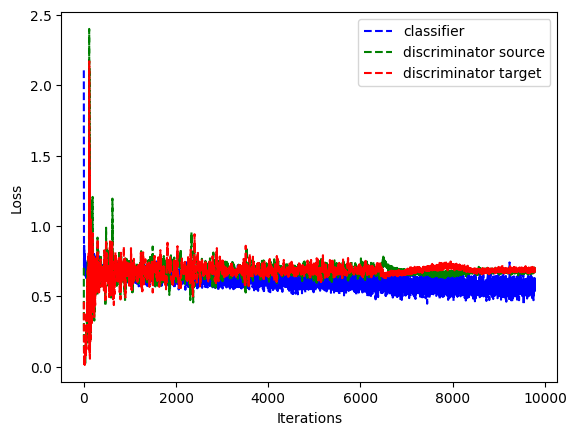

In [11]:
if USE_DOMAIN_ADAPTATION :
  # Plot losses 
  plotLosses(loss_class_list, loss_source_list, loss_target_list, n_epochs=len(loss_class_list), show=SHOW_IMG)